In [0]:
from sklearn.ensemble import RandomForestClassifier as RFC
import matplotlib.pyplot as plt
import random
import gc
import json
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
from pprint import pprint
from sklearn.feature_extraction.text import TfidfTransformer
from pylab import *
from scipy import *

In [24]:
df=pd.read_json('train.json')
submission_df=pd.read_json('test.json'

0    [romaine lettuce, black olives, grape tomatoes...
1    [plain flour, ground pepper, salt, tomatoes, g...
2    [eggs, pepper, salt, mayonaise, cooking oil, g...
3                  [water, vegetable oil, wheat, salt]
4    [black pepper, shallots, cornflour, cayenne pe...
Name: ingredients, dtype: object

In [27]:
df.head()
submission_df.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

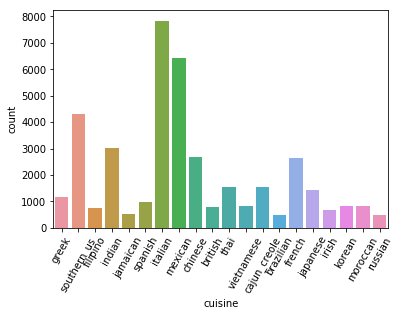

In [21]:
sns.countplot(x="cuisine", data=df)
plt.xticks(rotation=60)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


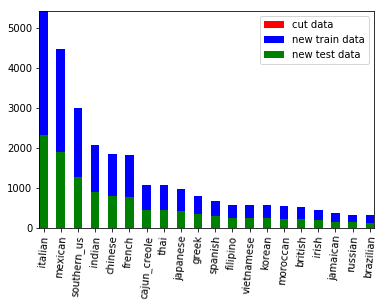

In [20]:
# We divide the original train data into 3 sets: 
# test_df will contain 30% recipes for each cuisine type
# train_df will contain 70% recipes for each cuisine type
# cut_df will contain the remaining data (could be used as another test set...) if exist

new_test_df=pandas.DataFrame()
new_train_df=pandas.DataFrame()
cut_df=pandas.DataFrame()
cut_percentage=0.01  
for cuisine in df['cuisine'].drop_duplicates().values :
    temp=pandas.DataFrame()
    temp=train_df[df['cuisine']==cuisine]
    rows_test = random.sample(list(temp.index), round(0.3*(1-cut_percentage)*len(train_df[train_df['cuisine']==cuisine])))
    new_test_df=new_test_df.append(temp.ix[rows_test])
    rows_train= random.sample(list(temp.drop(rows_test).index), round(0.7*(1-cut_percentage)*len(train_df[train_df['cuisine']==cuisine])))
    new_train_df=new_train_df.append(temp.ix[rows_train])
    rows=rows_test+rows_train
    cut_df=cut_df.append(temp.drop(rows))
    del temp

ax=plt.subplot()
CuisineCall = list(range(0,len(cut_df['cuisine'].value_counts().index)))
LABELS=cut_df['cuisine'].value_counts().index
ax.bar(CuisineCall,cut_df['cuisine'].value_counts(),width=0.5,color='r',align='center',label='cut data')
ax.bar(CuisineCall,new_train_df['cuisine'].value_counts(),width=0.5,color='b',align='center', label='new train data')
ax.bar(CuisineCall,new_test_df['cuisine'].value_counts(),width=0.5,color='g',align='center',label='new test data')
plt.xticks(CuisineCall, LABELS,rotation=85)
ax.autoscale(tight=True)
plt.legend()

plt.show()

In [0]:

with open('train.json') as data_file:    
    data = json.load(data_file)

In [0]:
def create_dict_cuisine_ingred(json):
    dictCuisineIngred = {}
    cuisines = []
    ingredients = []
    
    for i in range(len(json)):
        
        # just changing the name of one of the cuisines so
        # it is more readable in the final visualization
        cuisine = json[i]['cuisine']
        if cuisine == 'southern_us':
            cuisine = 'southUS'

        ingredientsPerCuisine = json[i]['ingredients']
        
        if cuisine not in dictCuisineIngred.keys():
            cuisines.append(cuisine)
            dictCuisineIngred[cuisine] = ingredientsPerCuisine
            
        else: 
            currentList = dictCuisineIngred[cuisine]
            currentList.extend(ingredientsPerCuisine)
            dictCuisineIngred[cuisine] = currentList
                 
        ingredients.extend(ingredientsPerCuisine)
         
    ingredients = list(set(ingredients)) # unique list of ALL ingredients
    numUniqueIngredients = len(ingredients)
    numCuisines = len(cuisines)
    
    return dictCuisineIngred, numCuisines, numUniqueIngredients, cuisines, ingredients


In [0]:

# This function prepares the data for tf-idf (before 
# running the tf-idf function you need to supply it
# with a a term-count matrix where rows (i) are cuisines, columns (j) are 
# ingredients and the value in cell [i,j] is the number of times
# the j'th ingredient appeared in the i'th cuisine.
##################################################################
def create_term_count_matrix(dictionary, numCuisines, numIngred, cuisines, ingredients):
    termCountMatrix = np.zeros((numCuisines,numIngred))
    i = 0
    
    for cuisine in cuisines:
        ingredientsPerCuisine = dictCuisineIngred[cuisine]

        for ingredient in ingredientsPerCuisine:
            j = ingredients.index(ingredient) #in order to know which column to put the term count in, we will ago according to the terms' order in the ingredients array
            termCountMatrix[i,j] += 1

        i += 1

    return termCountMatrix
    

dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients = create_dict_cuisine_ingred(data)
countsMatrix = create_term_count_matrix(dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients)

In [0]:
##################################################################
# SECTION 2: tf-idf + pca 
# This section creates 'reduced_data' which is the countsMatrix 
# above AFTER PCA where we took only the first two principal components
##################################################################

import pandas as pd
from scipy import sparse
from sklearn.decomposition import PCA
get_ipython().magic(u'matplotlib inline')

# This function creates the tf-idf matrix using a countsMatrix. 
# This creates a similar matrix to the one above, but this time
# the [i,j] cell is the tf-idf weight of ingredient j in
# cuisine i (instead of the counts)
##################################################################
def tf_idf_from_count_matrix(countsMatrix):
    
    countsMatrix = sparse.csr_matrix(countsMatrix)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(countsMatrix) # normalizes vectors to mean 0 and std 1 and computes tf-idf
    tfidf.toarray() 
    return tfidf.toarray()
  
# creating the tf-idf matrix
###########################################
tfIdf_Matrix = tf_idf_from_count_matrix(countsMatrix)


# running PCA to reduce to 2 dimensions
###########################################
pca = PCA(n_components=2)
# print(pca.explained_variance_ratio_)   
reduced_data = pca.fit_transform(tfIdf_Matrix)

# converting to pandas dataframe for convenience:
###########################################
pca2dataFrame = pd.DataFrame(reduced_data)
pca2dataFrame.columns = ['PC1', 'PC2']
  

In [0]:
##################################################################
# SECTION 3: KMEANS
##################################################################

from sklearn.cluster import KMeans

def kmeans_cultures(numOfClusters):
    
    kmeans = KMeans(init='k-means++', n_clusters=numOfClusters, n_init=10)
    kmeans.fit(reduced_data)
    return kmeans.predict(reduced_data)

labels = kmeans_cultures(3)


##################################################################
# SECTION 4: SIZE OF BUBBLES
# JACCARD SIMILARITY (one vs the other cuisines in its cluster)
# We intersect all ingredients of cuisine i with the union of 
# ingredients in all OTHER cuisines in its CLUSTER! (e.g.:
# intersect(filipino_Ingredients, other_asian_Ingredients)
# and divide by the union of all ingredients in the cluster.
##################################################################

i = 0 
j = 0 

effect_on_cluster = [0 for cuisine in cuisines]

for cuisineA in cuisines:  

    A_intersection = 0
    numInClusterBesidesA = 0
    setA = set(dictCuisineIngred[cuisineA])
    setB_forA = []
    j = 0
    
    for cuisineB in cuisines:
        if cuisineB != cuisineA: # if it is A itself - we obviously wouldn't want this (will be exactly 1)
            if labels[j] == labels[i]: #determines if then they are both in the same cluster
                setB_forA.extend(set(dictCuisineIngred[cuisineB]))
                numInClusterBesidesA += 1
        j += 1
    
    A_intersection = len(set(setA & set(setB_forA))) / float(len(set(setA.union(setB_forA))))
    effect_on_cluster[i] = A_intersection
    i += 1
     
      

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


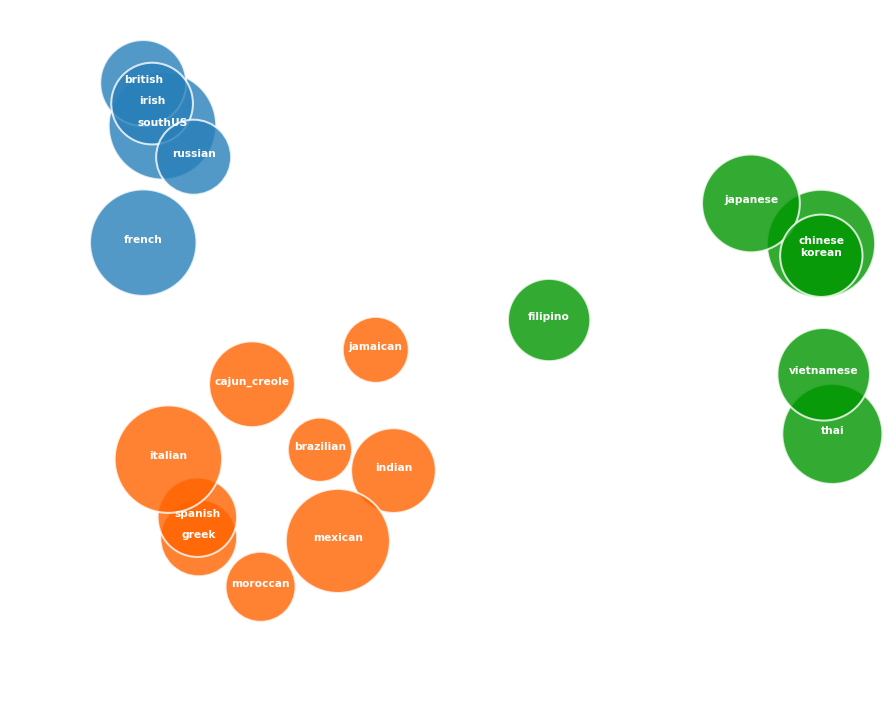

In [37]:
rdata = reduced_data
i=0
figureRatios = (15,20)
x = []
y = []
color = []
area = []

#creating a color palette:
colorPalette = ['#009600','#2980b9', '#ff6300','#2c3e50', '#660033'] 
# green,blue, orange, grey, purple

plt.figure(1, figsize=figureRatios)

for data in rdata:
    x.append(data[0]) 
    y.append(data[1])  
    color.append(colorPalette[labels[i]]) 
    area.append(effect_on_cluster[i]*27000) # magnifying the bubble's sizes (all by the same unit)
    # plotting the name of the cuisine:
    text(data[0], data[1], cuisines[i], size=10.6,horizontalalignment='center', fontweight = 'bold', color='w')
    i += 1

plt.scatter(x, y, c=color, s=area, linewidths=2, edgecolor='w', alpha=0.80) 

plt.axis([-0.45,0.65,-0.55,0.55])
plt.axes().set_aspect(0.8, 'box')

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.axis('off') # removing the PC axes

plt.show()

In [51]:
cv = CountVectorizer()
df['every_ingredients'] = df['ingredients'].map(";".join)
X = cv.fit_transform(df['every_ingredients'].values)
X.shape

from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
y = enc.fit_transform(df.cuisine)
y[:100]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
logistic.score(X_test, y_test)

0.788686360779384

In [54]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)


from sklearn.neighbors import KNeighborsClassifier
neighbor=KNeighborsClassifier()
neighbor.fit(X_train,y_train)

neighbor.score(X_test, y_test)

0.6306725329981144

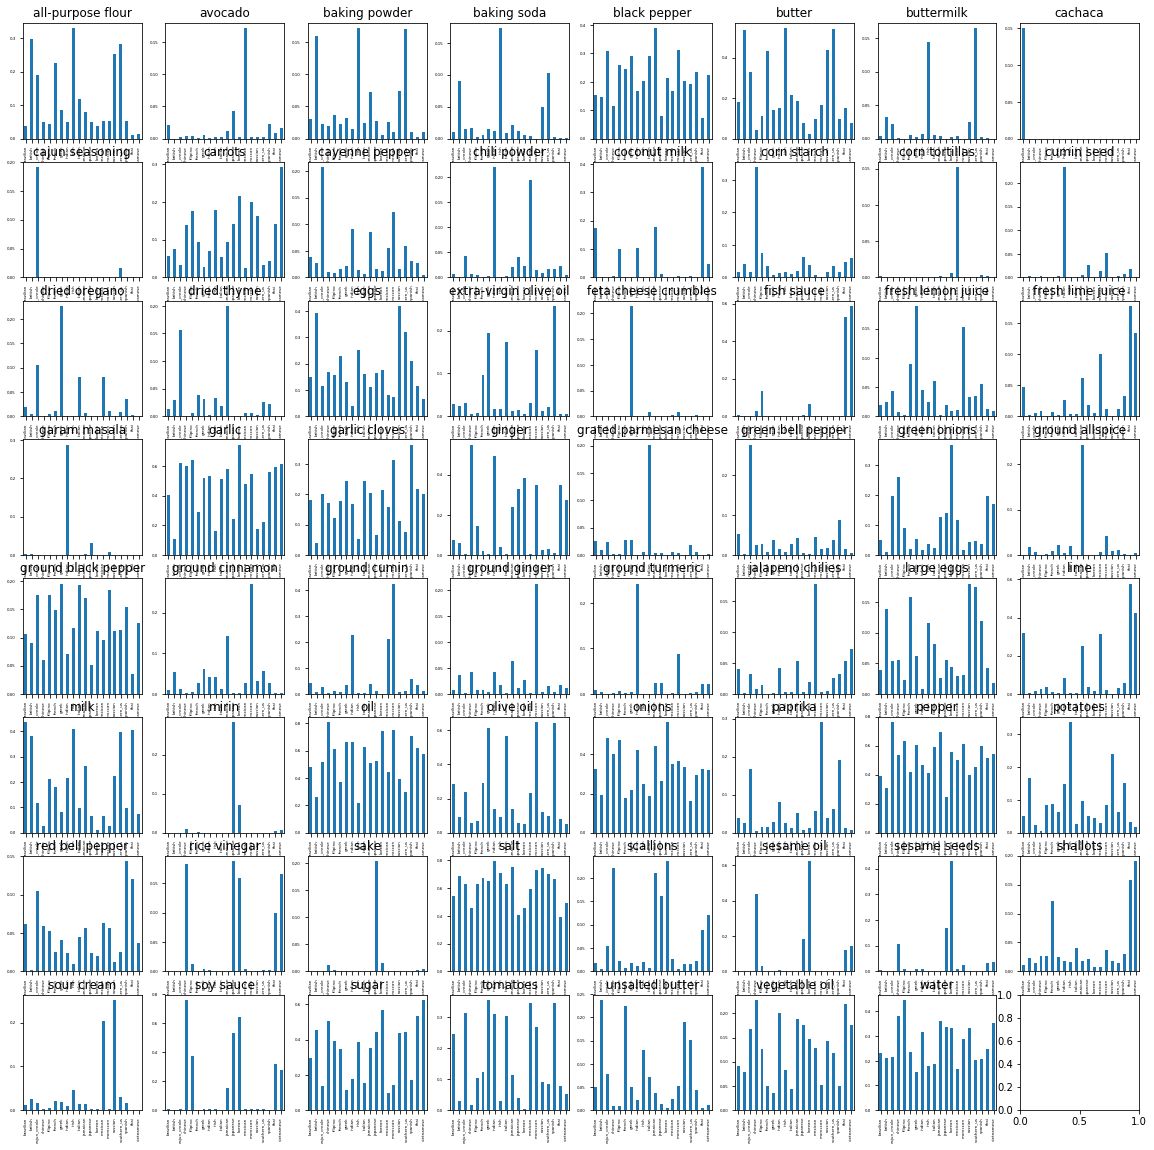

In [64]:
from collections import Counter
counters = {}
for cuisine in df['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (df['cuisine'] == cuisine)
    for ingredients in df[indices]['ingredients']:
        counters[cuisine].update(ingredients)


top10 = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=['top{}'.format(i) for i in range(1, 11)])
top10
unique = np.unique(top10.values.ravel())


fig, axes = plt.subplots(8, 8, figsize=(20, 20))
for ingredient, ax_index in zip(unique, range(64)):
    indices = df['every_ingredients'].str.contains(ingredient)
    relative_freq = (df[indices]['cuisine'].value_counts() / df['cuisine'].value_counts())
    relative_freq.plot(kind='bar', ax=axes.ravel()[ax_index], fontsize=4, title=ingredient)



Text(0.5, 64.59999999999997, 'Predicted label')

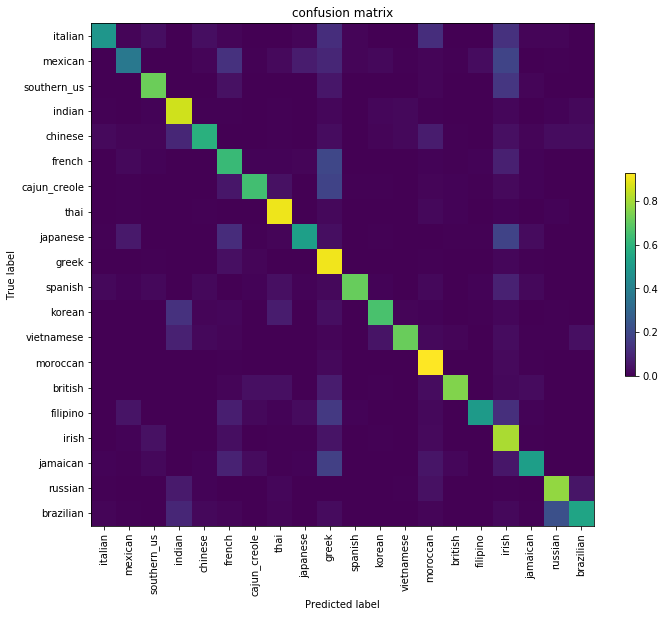

In [57]:
#Inspecting the classification results using a confusion matrix
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 10))

cm = confusion_matrix(y_test, logistic.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest')
plt.title("confusion matrix")
plt.colorbar(shrink=0.3)
cuisines = df['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')